In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

In [ ]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [4]:
from mnist1d_utils import *

# Dataset

In [5]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

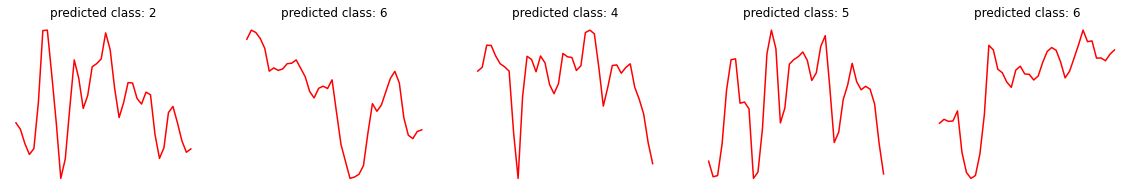

In [6]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

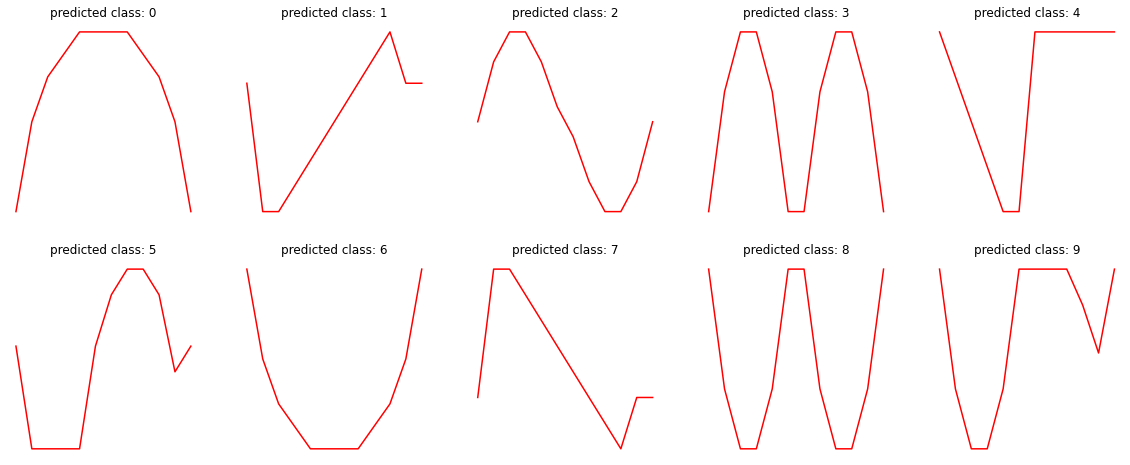

In [7]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [8]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [9]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv1D(filters=25, kernel_size=(5), padding='same', activation='relu', input_shape=(40,1), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=(3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(filters=25, kernel_size=(3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

Printing the model's summary.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 25)            150       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 25)            1900      
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10010     
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD)

Tensorboard: For recording the training procedure

In [11]:
# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01),
              metrics=['accuracy'])

tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log', write_graph=True)

In [ ]:
model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, callbacks=[tensorboard_cb], epochs=200)

Epoch 1/200
113/113 [==============================] - 1s 7ms/step - loss: 3.6242 - accuracy: 0.1734 - val_loss: 3.4174 - val_accuracy: 0.2075
Epoch 2/200
113/113 [==============================] - 0s 4ms/step - loss: 3.3412 - accuracy: 0.2630 - val_loss: 3.3357 - val_accuracy: 0.2850
Epoch 3/200
113/113 [==============================] - 0s 4ms/step - loss: 3.2731 - accuracy: 0.2751 - val_loss: 3.2696 - val_accuracy: 0.2950
Epoch 4/200
113/113 [==============================] - 0s 4ms/step - loss: 3.2087 - accuracy: 0.3027 - val_loss: 3.2335 - val_accuracy: 0.2850
Epoch 5/200
113/113 [==============================] - 0s 4ms/step - loss: 3.0993 - accuracy: 0.3325 - val_loss: 3.1582 - val_accuracy: 0.3200
Epoch 6/200
113/113 [==============================] - 0s 4ms/step - loss: 3.0526 - accuracy: 0.3454 - val_loss: 3.1070 - val_accuracy: 0.3275
Epoch 7/200
113/113 [==============================] - 0s 4ms/step - loss: 2.9677 - accuracy: 0.3870 - val_loss: 3.0204 - val_accuracy: 0.3550

Save the model

In [ ]:
model.save('MNIST1D.h5')

# Plotting the training progress

# Load the model

In [12]:
model=load_model('MNIST1D.h5')

Loading training progress



In [ ]:
def my_summary_iterator(path):
  for r in tf_record.tf_record_iterator(path):
    yield event_pb2.Event.FromString(r)
train_acc = []
train_loss = []
train_lr = []
#print('log/train/' + os.listdir('log/train')[2])
for e in my_summary_iterator('log/train/' + os.listdir('log/train')[2]):
  for v in e.summary.value:
    if v.tag == 'epoch_accuracy':
      train_acc.append(v.simple_value)
    elif v.tag == 'epoch_loss':
      train_loss.append(v.simple_value)

Text(0.5, 1.0, 'Training progress: Accuracy')

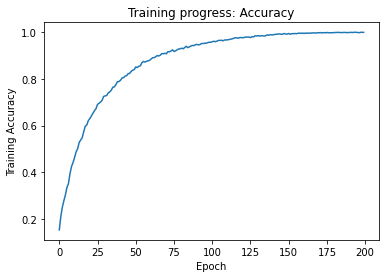

In [ ]:
plt.plot(np.arange(len(train_acc)), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training progress: Accuracy')

Text(0.5, 1.0, 'Training progress: Loss')

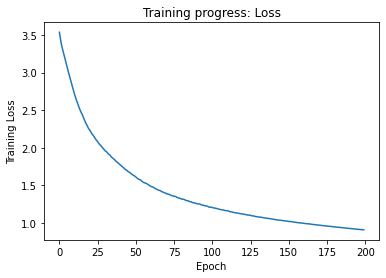

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training progress: Loss')

# Explanation

In [13]:
from xai_utils import *

Take a test sample

In [14]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [15]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 1.0


## SISE (Semantic Input Sampling for Explanation)

In [16]:
explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

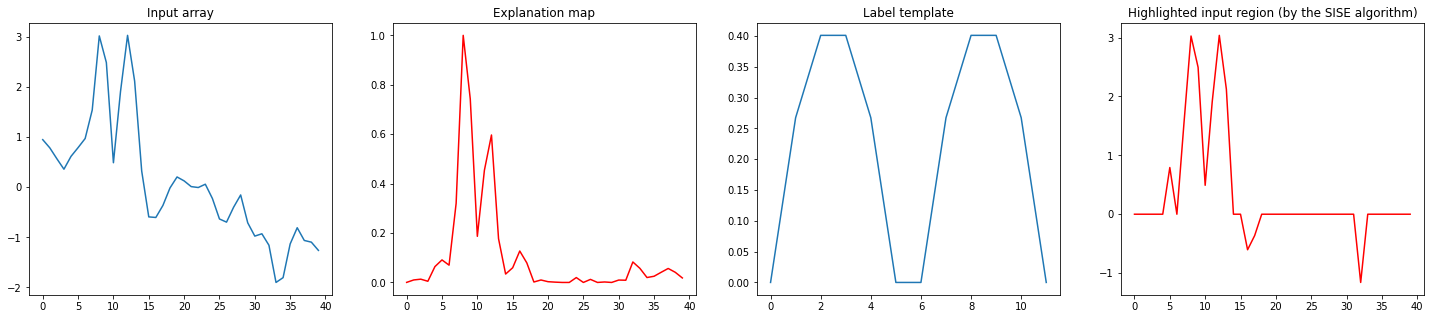

In [17]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## Grad-CAM

In [18]:
explanation = grad_cam(model, input, 'conv1d_2')

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

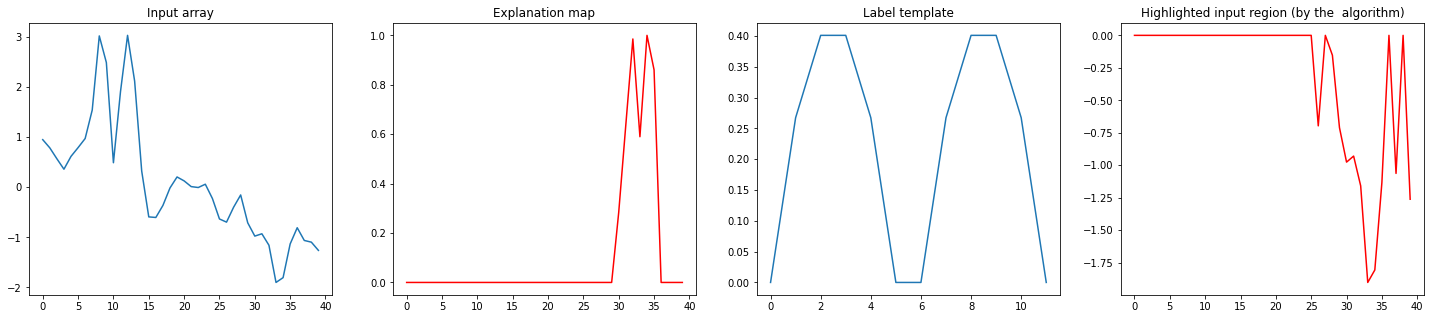

In [19]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

## Quantitative evaluation

In [20]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Getting the prediction for image
    Y=predictions[0][class_index]
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
drop_rate = 0.
for index in range(1000):
  prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
  explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
  drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0]
drop_rate /= 1000

## Part 1: 1-D digit classification

### Task \#1: 1-Dimensional digit classification

#### 1a. Overall classification accuracy on the test set

In [21]:
x_test_reshape = []
for i in range(len(y_test)):
  x_test_reshape.append(np.expand_dims(x_test[i], axis=1))
x_test_reshape = np.array(x_test_reshape)

In [22]:
y_pred = np.argmax(model.predict(x_test_reshape), axis=1)

In [23]:
print('Overall classification Test Accuracy:', metrics.accuracy_score(y_test, y_pred))

Overall classification Test Accuracy: 0.877


#### 1b. Class-wise classification accuracy for all classes

In [24]:
m = metrics.confusion_matrix(y_test, y_pred)
class_wise_acc = m.diagonal() / m.sum(axis=1)

In [25]:
print('Class-wise classification accuracy on test set\n')
for i in range(10):
  print('Class',i,'accuracy:',class_wise_acc[i],'\n')

Class-wise classification accuracy on test set

Class 0 accuracy: 0.9803921568627451 

Class 1 accuracy: 0.8076923076923077 

Class 2 accuracy: 0.8876404494382022 

Class 3 accuracy: 0.9433962264150944 

Class 4 accuracy: 0.8490566037735849 

Class 5 accuracy: 0.8163265306122449 

Class 6 accuracy: 0.9191919191919192 

Class 7 accuracy: 0.8645833333333334 

Class 8 accuracy: 0.9183673469387755 

Class 9 accuracy: 0.7843137254901961 



#### 1c. ROC & AUC curves for each class

Note: The blue curve represents the ROC curve and the light pink region is the AUC, the area under the ROC curve.

AUC score for class 0 : 0.9995087121708371
AUC score for class 1 : 0.9903738839285714
AUC score for class 2 : 0.9818325337016983
AUC score for class 3 : 0.9997572917985733
AUC score for class 4 : 0.9883922164535055
AUC score for class 5 : 0.9847730666545998
AUC score for class 6 : 0.9981502034776175
AUC score for class 7 : 0.9917265855457227
AUC score for class 8 : 0.9973188832073849
AUC score for class 9 : 0.9716472335036465


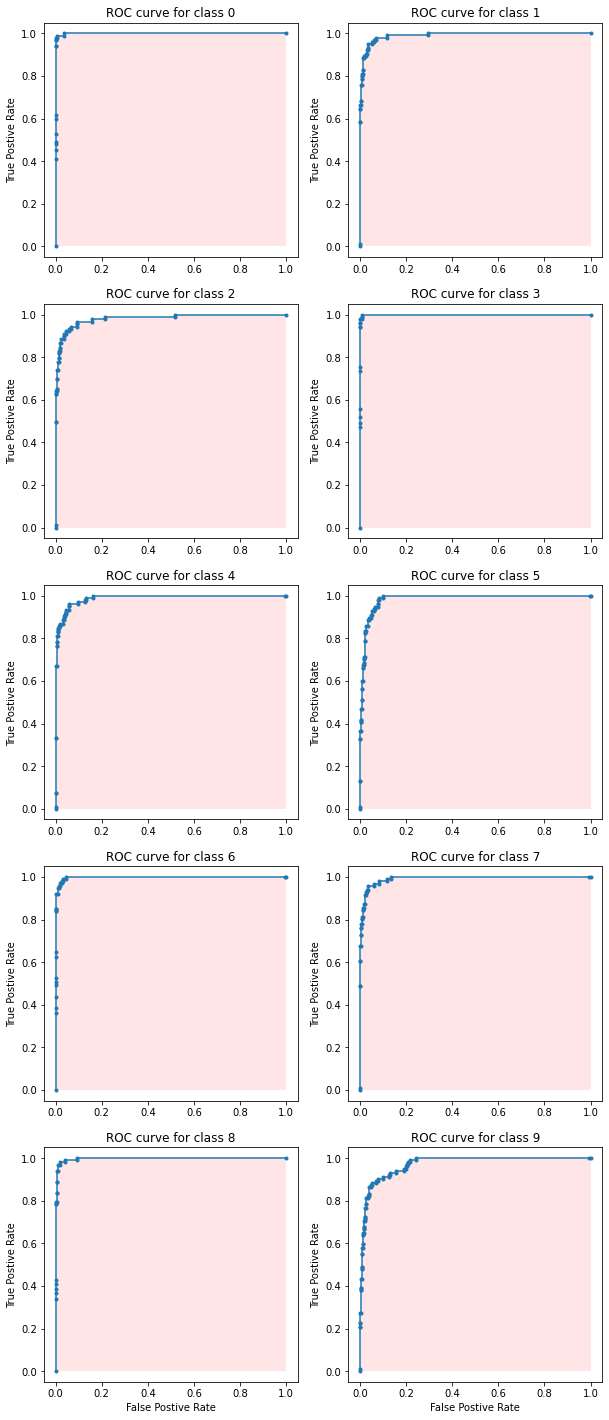

In [26]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,25))
for i in range(10):
  probs = model.predict(x_test_reshape)[:,i]
  y_binary = y_test == i
  auc = metrics.roc_auc_score(y_binary, probs)
  print('AUC score for class',i,':',auc)
  fpr, tpr, _ = metrics.roc_curve(y_binary, probs, pos_label=True)
  # Plot the ROC-AUC curve for each digit class
  axs[i//2,i%2].plot(fpr, tpr, marker='.')
  axs[i//2,i%2].set_title('ROC curve for class '+str(i))
  if i//2 == 4:
    axs[i//2,i%2].set(xlabel='False Postive Rate')
  axs[i//2,i%2].set(ylabel='True Postive Rate')
  axs[i//2,i%2].fill_between(fpr, tpr,facecolor='red', alpha=.1)

#### 1d. Plot the normalized confusion matrix

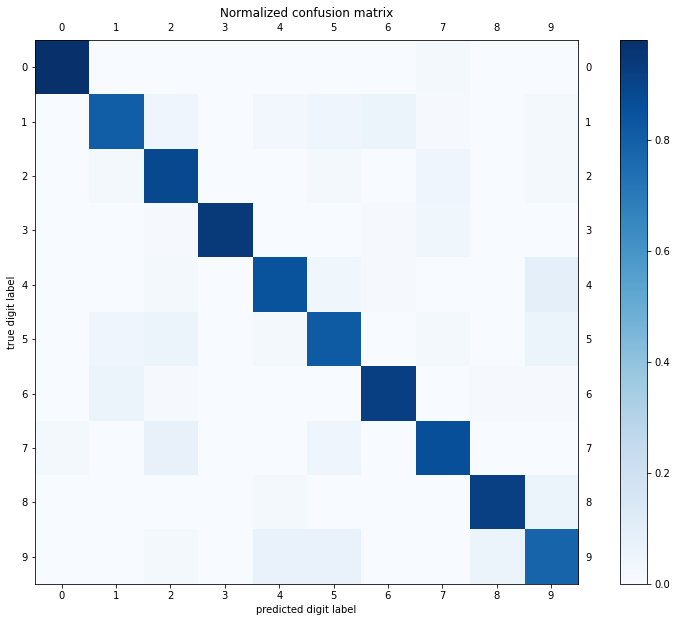

In [27]:
normalized_cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (15,10))
plt.imshow(normalized_cm, cmap=plt.cm.Blues)
plt.xlabel("predicted digit label")
plt.ylabel("true digit label")
plt.xticks(np.arange(10), labels=range(10), visible=True)
plt.yticks(np.arange(10), labels=range(10), visible=True)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.show()

#### 1e. Precision, Recall, F-1 score on test set

In [28]:
print('Overall classification Test Precision:',metrics.precision_score(y_test, y_pred, average='micro'))
print('Overall classification Test Recall:',metrics.recall_score(y_test, y_pred, average='micro'))
print('Overall classification Test F-1:',metrics.f1_score(y_test, y_pred, average='micro'))

Overall classification Test Precision: 0.877
Overall classification Test Recall: 0.877
Overall classification Test F-1: 0.8769999999999999


#### 2. Qualitative Examples

In [29]:
def show_qual_ex(dataset, index):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = y_test[index]
  pred = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())
  print('Correct digit: '+str(label))
  print('Predicted digit: '+str(pred))
  print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
  
  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(input[0])
  plt.title('Input array')

  plt.subplot(1,3,2)
  plt.plot(dataset['templates']['x'][label])
  plt.title('True label template')

  plt.subplot(1,3,3)
  plt.plot(dataset['templates']['x'][pred])
  plt.title('Predicted label template')

Failure case

Failure case:
Input at index: 10
Correct digit: 0
Predicted digit: 7
Confidence score for the correct label: 0.0039541037


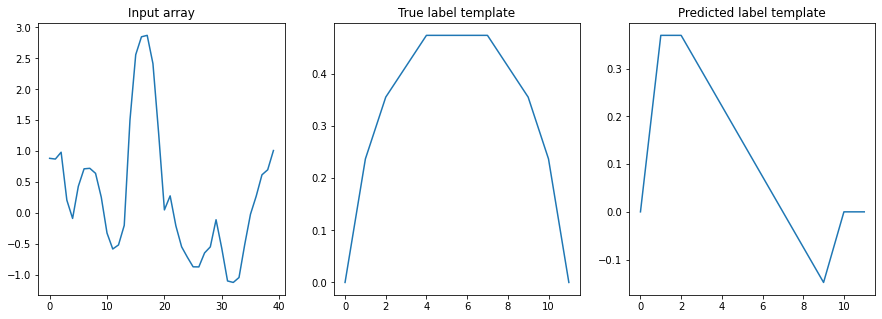

In [92]:
print('Failure case:')
print('Input at index:',10)
show_qual_ex(dataset, 10)

Sucessful case

Success case:
Input at index: 9
Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 0.9976661


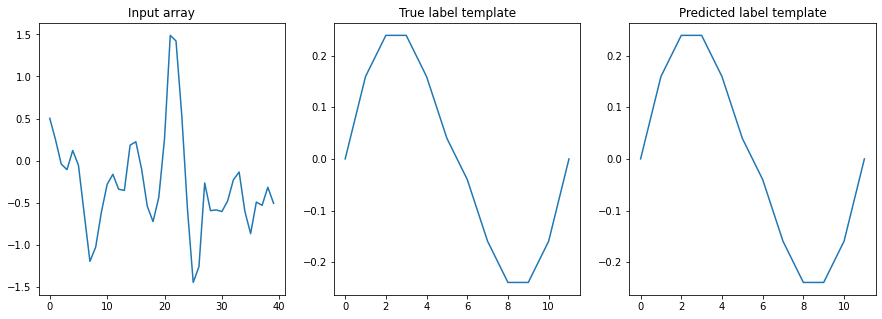

In [93]:
print('Success case:')
print('Input at index:',9)
show_qual_ex(dataset, 9)

Two classes misclassification happens the most

In [32]:
maximum = 0.0
mis_i, mis_j = 0, 0
for i in range(normalized_cm.shape[0]):
  for j in range(normalized_cm.shape[1]):
    curr = normalized_cm[i,j]
    if maximum < curr and i!=j:
      maximum = curr
      mis_i, mis_j = i, j
print('Misclassification happens the most between digit',mis_i,'and','digit',mis_j)
print('Misclassification rate:',maximum)

Misclassification happens the most between digit 4 and digit 9
Misclassification rate: 0.08490566037735849


Insights and reasoning

From the confusion matrix computed above, we found that digit 4 and digit 9 are misclassified the most among all possible two digits. About 8.4% of the number of digit samples known to be digit 4 but are predicted to be digit 9. Below are the digit templates for the 4 and 9, they both have a concave shape around x range 2 to 5 and a flat line from x range 5 to 8. These similarities could possibly make these two digits hard to distinguish. Thus, this results in the most misclassifications between the two digit classes.  

Text(0.5, 1.0, 'Digit 9 template')

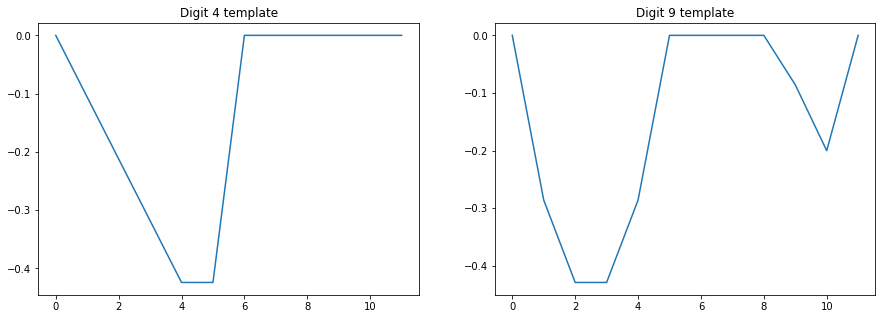

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(dataset['templates']['x'][4])
plt.title('Digit 4 template')

plt.subplot(1,2,2)
plt.plot(dataset['templates']['x'][9])
plt.title('Digit 9 template')

### Task \#2: CNN interpretation

#### 1.1: Research gap filled and novelty

The Ablation-CAM is a CAM-based attribution method. It makes improvements for the Grad-CAM method. As it retrieves a more accurate class-discriminative localization map. The main research gap that Ablation-CAM filled was to localize main features of images without training images on it. This approach effectively generates a complete and better localization of potential image features. The novelty of Ablation-CAM is to apply a gradient-free approach to overcome the problem of gradient saturation during backpropagation where the gradient may diminish. Thus, the localization map of Ablation-CAM provides a better interpretable and explainable visualization for human to understand.

#### 1.2: Methodology full detail

First, perform a forward pass through the CNN model for a given image $I$ to produce the activation score $y_c$ for class $c$. The value $y_c$ is produced when using the non-linear function of feature maps $A_k$. Then, set each activation cell of the feature map $A_k$ to zero and perform a second forward pass through the CNN model again on the same image $I$. By doing this, it produces the $y^c_k$ which results the values of the model when ablated the activation of the feature map $A_k$. Intuitively, without the process of passing through $A_k$, it may lead to a reduced activation score and it could provide information about how important the feature map is quantitatively. Notice that in my implementation of Ablation-CAM below, in order to zero out the activation scores of the feature map $A_k$, I construct two separate models, model_$1$ and model_$2$. The model_$1$ generates the activation signals that going from original model's input layer to the last original model's layer right before the final activation layer, in this case, 'conv1d_2' is the final activation layer. The model_$2$ consists of an new input layer that takes in output from the model_$1$ and followed by the remaining layers from the original CNN model to make predictions. In this way, it effectively exclude the $A_k$ and obtain $y^c_k$. To continue to measure how important the feature map $A_k$ is, the paper proposed the following equation to calculate $w^c_k$<br><br>
$w^c_k = \frac{y_c-y^c_k}{y_c}$<br><br>
The weights $w^c_k$ means what proportion is the drop in activation scores after removed feature map $A_k$. As per the paper, this equation is more practical to use than the following version of dividing the norm $||A_k||$ since it it too large compared to the $y_c-y^c_k$.<br><br>
$slope=\frac{y_c-y^c_k}{||A_k||}$<br><br>
Then, after retrieving the weight, $w^c_k$ for each k, perform a weighted linear combination of activation maps and corresponding weights and followed by the $ReLU$ function to filter out negative drop in class score. The paper proposed the equation below.<br><br>
$L^c_{Ablation-CAM}=ReLU(\sum_k{w^c_k A_k})$<br><br>
Finally, resize the localization map $L^c_{Ablation-CAM}$to the shape of orignal image. We are now able to visualize which regions of the image are lighted for human interpretations. 

#### 1.3: Advantages, Disadvantages, Discussions

Advantages:

*   Ablation-CAM effectivly solve the problem of gradient saturation. This will capture more important and accurate features in the resulting localization map.
*   Ablation-CAM performs better in tasks like image captioning. This is due to the last convolutional layer comes before some other layers consist of non-decision nodes.

Disadvantages:
*   The computational time for generating Ablation-CAM is larger than the that using Grad-CAM due to the fact that Ablation-CAM requires to loop over each feature map and zero out the activation and produce the drop class activation scores. Whereas, the Grad-CAM utilizes backpropagating gradient in a single run which is faster.
*   For some models that do not have any fully-connected layers such as Resnet-50 and Inception-v3, the Ablation-CAM does not make a large improvement compared to Grad-CAM.

Difficult scenarios:

In difficult scenarios like applying on deep CNN models, Ablation-CAM should performs well and give interpretable visualizations. For images that contain lots of texture and noises, this algorithm will also perform well since Ablation-CAM provides a baseline for each feature map. As per the paper, intuitively, it compute the 'discrete gradients' instead of instantaneous gradients.

Case of misclassification:

Ablation-CAM can not analyze the case of misclassification by the target model since it only localize the main features on the image which does not provide any classification related information for a given image.

#### 2.a: Choose 3 different inputs

Implement the Ablation-CAM algorithm according to paper: https://openaccess.thecvf.com/content_WACV_2020/html/Desai_Ablation-CAM_Visual_Explanations_for_Deep_Convolutional_Network_via_Gradient-free_Localization_WACV_2020_paper.html

In [34]:
def ablation_cam(input_model, image, layer_name):
  cls = np.argmax(input_model.predict(image))
  # Activation score when feature map A_k is present
  activation_score = input_model.predict(image)[0][cls]
  
  # Retrieve the feature map A_k for the given layer_name 
  conv_output = input_model.get_layer(layer_name).output
  feedforward = keras.models.Model([input_model.input], [conv_output, input_model.output])
  ff_results = feedforward([image])
  A_k = ff_results[0]
  
  # Forward pass through the model to produce y_c when A_k is present
  y_c = np.array([activation_score]*A_k.shape[2])

  # Idea from paper: 
  # Ablate that layer's activation and maintain other activation layer to W_k^c.
  # Ablated the given layer's activation map
  layers = input_model.layers
  layer_index = layers.index(input_model.get_layer(layer_name))
  pre_outputs = [layer.output for layer in layers[:layer_index]]

  # model_1: produce activation scores before input to the given layer_name
  model_1 = keras.models.Model(inputs=input_model.input, outputs=pre_outputs)
  
  # Construct input and output for model_2
  model_2_input_shape = layers[layer_index].output.shape[1:]
  model_2_input = keras.Input(shape=model_2_input_shape)
  # Construct forward pass flow for model_2
  tmp = model_2_input
  layer_it = iter(layers[layer_index+1:])
  for _ in range(layer_index+1,len(layers)):
    tmp = next(layer_it)(tmp)

  # model_2: use above input and output to construct model_2 for classifying 
  # the activation signals from model_1 (i.e. remove layer_name's activation layer)
  model_2 = keras.models.Model(inputs=model_2_input, outputs=tmp)
  
  k = layers[layer_index].output.shape[2]
  # List of activations score when feature map A_k is removed
  y_c_k = []
  # For each feature map A_k, remove it to compute y_c_k
  for i in range(k):
    activations = model_1.predict(image) # (1,40,25)
    ac_np = activations[1]
    ac_np[0][:][i] = 0.0
    pred = model_2(ac_np)
    y_c_k.append(pred[0][cls])
  y_c_k = np.array(y_c_k) # y_c_k: (25,)
  
  # Divide by y_c instead of ||A_k|| as per the paper
  weights = (y_c - y_c_k) / y_c # A_k[0]:(40,25), weights:(25,)
  # weighted linear combination of activation maps and corresponding weights
  cam = np.mean(A_k[0] * weights,axis=1) # cam:(40,)
  H,W= image.shape[1:3]
  cam = np.maximum(cam, 0)
  cam = zoom(cam,H/cam.shape[0])
  cam = cam / cam.max()
  return cam

In [35]:
def plot_explanation_map(explanation, input, label, dataset): 
  threshold = np.sort(explanation)[-12]

  plt.figure(figsize=(25,5))

  plt.subplot(1,4,1)
  plt.plot(input[0])
  plt.title('Input array')

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map')

  plt.subplot(1,4,3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Label template')

  plt.subplot(1,4,4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the  algorithm)')

Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 1.0


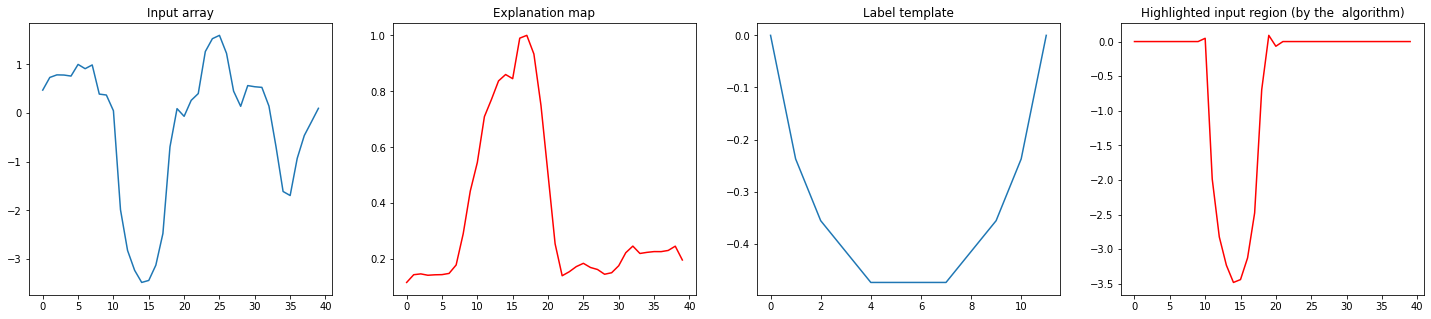

In [36]:
index1 = 1
input1 = np.expand_dims(np.expand_dims(x_test[index1], axis=0), axis=-1)
label1 = y_test[index1]
print('Correct digit: '+str(label1))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index1], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index1], axis=0), axis=-1)).numpy()[0,label1]))
explanation1 = ablation_cam(model, input1, 'conv1d_2')
plot_explanation_map(explanation1, input1, label1, dataset)

Correct digit: 5
Predicted digit: 5
Confidence score for the correct label: 0.9999453


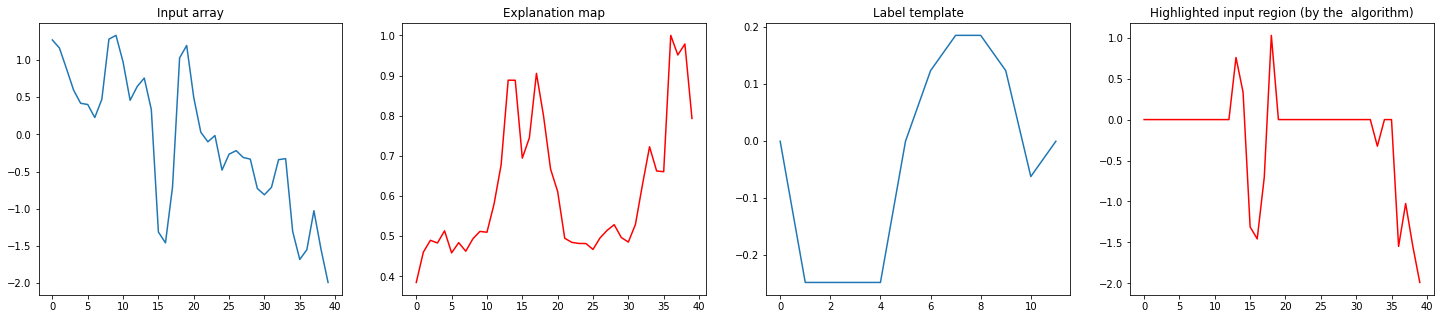

In [37]:
index2 = 8
input2 = np.expand_dims(np.expand_dims(x_test[index2], axis=0), axis=-1)
label2 = y_test[index2]
print('Correct digit: '+str(label2))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index2], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index2], axis=0), axis=-1)).numpy()[0,label2]))
explanation2 = ablation_cam(model, input2, 'conv1d_2')
plot_explanation_map(explanation2, input2, label2, dataset)

Correct digit: 9
Predicted digit: 9
Confidence score for the correct label: 0.9623548


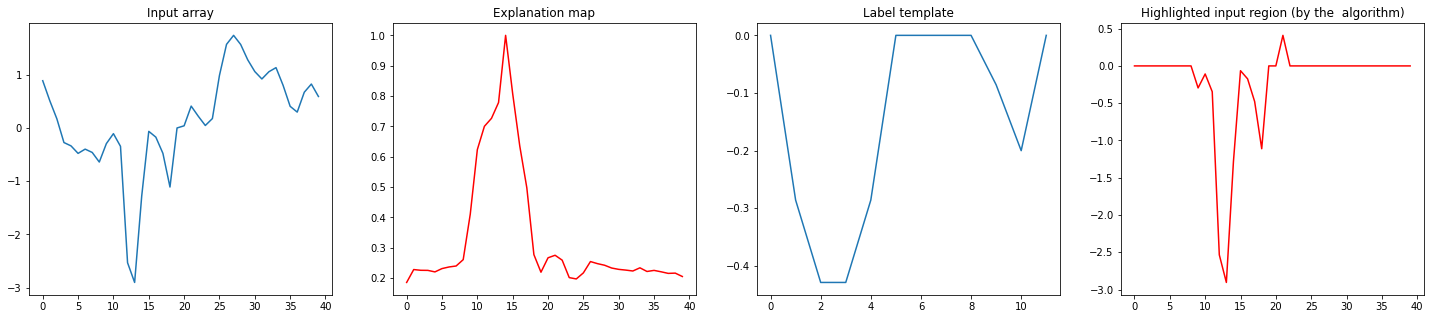

In [38]:
index3 = 20
input3 = np.expand_dims(np.expand_dims(x_test[index3], axis=0), axis=-1)
label3 = y_test[index3]
print('Correct digit: '+str(label3))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index3], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index3], axis=0), axis=-1)).numpy()[0,label3]))
explanation3 = ablation_cam(model, input3, 'conv1d_2')
plot_explanation_map(explanation3, input3, label3, dataset)

#### 2.b: Qualitative report

1.   For the first input, the true label is $6$ and the model predicts it as $6$ which is correct. The confidence score is $1.0$. From the explanation map, we can observe that the highest score achieved is $1$ at around value $15$ on the x-axis. Moreover, comparing the label template and the highlighted input region, we conclude they are pretty similar to each other. Notice that the highlighted region also localizes the main features as both of them are concave-up bowl shape. It means the explanation map produced by the Ablation-CAM method is pretty accurate.

2.   For the second input, the true label is $5$ and the model predicts it as $5$ which is correct. The confidence score is around $0.99$. From the explanation map, we can observe that the highest score achieved is $0.99$ at around value $36$ on the x-axis. The second highest score achieved is around $0.91$ at value $17$ on the x-axis. Moreover, comparing the label template and the highlighted input region, we conclude that the highlighted region from $13$ to $18$ on x-axis matches with the label template in shape pretty closely. Whereas, the region from $35$ to $40$ also matches with the template in shape but differ in detail and in size. 

3.   For the third input, the true label is $9$ and the model predicts it as $9$ which is correct. The confidence score is $0.96$. From the explanation map, we can observe that the highest score achieved is close to $1$ at value $14$ on the x-axis. Moreover, comparing the label template and the highlighted input region, we conclude they are pretty similar to each other. Notice that the highlighted region also localizes the main features as both of them are a deep concave-up bowl shape on the left and a shallow concave-up triangle shape on the right. It means the explanation map produced by the Ablation-CAM method captures an accurate localization map. 

In conclusion, the explantion map accuratly shows the local behavior of the model and generates an interpretable visualization of the model well.


### Task \#4: Quantitative evaluation of the attribution methods

#### 4.1: Drop rate & Increase rate of Ablation-CAM on MNIST-1D dataset

In [129]:
drop_rate_AbCAM, incr_rate_AbCAM = 0., 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  prediction = model(input).numpy()
  expln_map_AbCAM = ablation_cam(model, input, 'conv1d_2')
  (drop, incr, Y, O1) = calculate_drop_increase(input, model, np.expand_dims(expln_map_AbCAM,axis=-1), class_index=np.argmax(prediction[0]), frac=0.3)
  drop_rate_AbCAM += drop
  incr_rate_AbCAM += incr
drop_rate_AbCAM /= 1000
incr_rate_AbCAM /= 1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


In [150]:
print('Using Ablation-CAM with k=0.3')
print('-Drop rate:',drop_rate_AbCAM,'\n-Increase rate:',incr_rate_AbCAM)

Using Ablation-CAM with k=0.3
-Drop rate: 0.16935188024666767 
-Increase rate: 0.341


#### 4.2: Discussion of Ablation-CAM on MNIST-1D dataset

On the MNIST-1D dataset, using the Ablation-CAM to generate the explanation map, the average drop rate is $0.169$ and the average increase rate is $0.341$ on the whole test set with each image retaining the top $30\%$ of the pixels. 

In order to demonstrate how successful the Ablation-CAM performs in interpreting the target model, I compared it with the other two provided attribution methods, SISE and Grad-CAM. Calculate the average drop rate and average increase rate of each of them. The results are shown as following.

In [90]:
drop_rate_s, incr_rate_s = 0., 0.
drop_rate_g, incr_rate_g = 0., 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  prediction = model(input).numpy()
  
  SISE_map = SISE(input, model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
  (drop_s, incr_s, Y_s, O1_s) = calculate_drop_increase(input, model, SISE_map, class_index=np.argmax(prediction[0]), frac=0.3)
  
  GradCAM_map = grad_cam(model, input, 'conv1d_2')
  (drop_g, incr_g, Y_g, O1_g) = calculate_drop_increase(input, model, np.expand_dims(GradCAM_map,axis=-1), class_index=np.argmax(prediction[0]), frac=0.3)

  drop_rate_s += drop_s
  incr_rate_s += incr_s
  drop_rate_g += drop_g
  incr_rate_g += incr_g

drop_rate_s /= 1000
incr_rate_s /= 1000
drop_rate_g /= 1000
incr_rate_g /= 1000

/content/xai_utils.py:363: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


In [91]:
print('k=0.3\n')
print('SISE')
print('-Drop rate:',drop_rate_s,'\n-Increase rate:',incr_rate_s,'\n')
print('Grad-CAM')
print('-Drop rate:',drop_rate_g,'\n-Increase rate:',incr_rate_g,'\n')

k=0.3

SISE
-Drop rate: 0.1371740567880671 
-Increase rate: 0.375 

Grad-CAM
-Drop rate: 0.4113007747696008 
-Increase rate: 0.3 



We expect the drop rate to be low and increase rate to be high, comparing the above three attribution methods. Notice that when retaining the top $30\%$ of the pixels, SISE achieved the lowest drop rate $0.137$, Ablation-CAM achieved the second lowest drop rate $0.169$ and Grad-CAM achieved the highest drop rate $0.411$. On the other hand, SISE achieved the highest increase rate $0.375$, Ablation-CAM achieved the second highest increase rate $0.341$ and Grad-CAM achieved the lowest increase rate $0.3$. In conclusion, among all the three methods, SISE is the most successful attribution method to interpret the given model. Ablation-CAM is the second best one and Grad-CAM is the worst. Also, notice that Ablation-CAM indeed makes improvements on Grad-CAM especially in ignoring unimportant features of each input array which causes the drop rate to be low. From the previous output results, like 2.a, Ablation-CAM mainly focuses on the most important features that are similar to the true label. As a result, it explains the model pretty well.

In [86]:
def exp_pred(images, model, exmap, frac=0.15):
  img = images[0,:,:]
  img = np.expand_dims(img,axis=0)

  grad_array = np.reshape(exmap, (-1,))
  array_size = int(grad_array.shape[0]*frac)
  thr = np.flip(sorted(grad_array))[array_size]
  exmap1_msk = (exmap>thr)
  exmap1_thr = np.zeros(shape=(1,40,1))
  exmap1_thr = img*exmap1_msk

  ex_predictions = model.predict(exmap1_thr)[0]
  y_exp = np.argmax(ex_predictions)
  y_exp_confidence = ex_predictions[y_exp]
  
  return y_exp, y_exp_confidence
  
idx = 15
input = np.expand_dims(np.expand_dims(x_test[idx], axis=0), axis=-1)
y_true = y_test[idx]
predictions = model(input).numpy()[0]
y = np.argmax(predictions)
y_confidence = predictions[y]

expln_map_AbCAM = ablation_cam(model, input, 'conv1d_2')
y_exp, y_exp_confidence = exp_pred(input, model, 
                                         np.expand_dims(expln_map_AbCAM,axis=-1), frac=0.3)

Cases where Ablation-CAM fails to explain the target model's prediction

In [87]:
print('True label:', y_true, '\nImage index:',idx)
print('\nComplete input')
print('- Prediction:', y_pred,'\n- Confidence score:', y_confidence)
print('\nExplanation map processed input')
print('- Prediction:', y_pred_exp, '\n- Confidence score:', y_pred_confidence)

True label: 6 
Image index: 15

Complete input
- Prediction: 6 
- Confidence score: 0.99865437

Explanation map processed input
- Prediction: 4 
- Confidence score: 0.99102575


Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

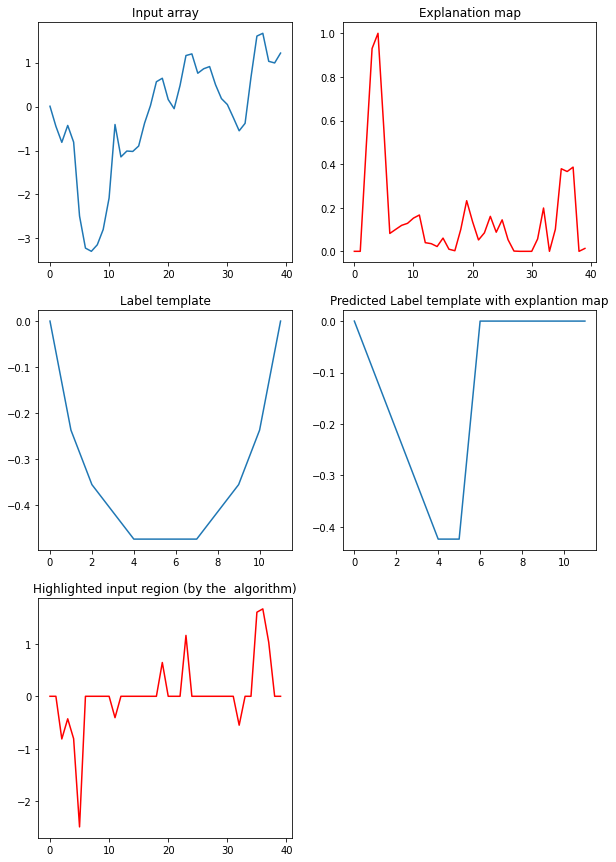

In [88]:
threshold = np.sort(expln_map_AbCAM)[-12]

plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(3,2,2)
plt.plot(expln_map_AbCAM, 'r')
plt.title('Explanation map')

plt.subplot(3,2,3)
plt.plot(dataset['templates']['x'][y_true])
plt.title('Label template')

plt.subplot(3,2,4)
plt.plot(dataset['templates']['x'][y_pred_exp])
plt.title('Predicted Label template with explantion map')

plt.subplot(3,2,5)
plt.plot((input[0,:,0]*(expln_map_AbCAM>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

From above outputs and figures, the explanation map produced by Ablation-CAM captures two important features from the input array. The first feature captured is a concave-up bowl shape around $8$th on x-axis. The second feature captured is a cancave-up triangle shape around $36$th on x-axis. The model with a complete input correctly predicts it as digit $6$. However, the model with the input processed by the explanation map fails to make correct prediction as the Ablation-CAM highlights the second feature as a more important feature than the first one for class $6$ (As the figure, 'Highlighted input region (by the algorithm)' shown). Notice the true label template and the predicted label template with explanation map have quite similar shape in general, that tricks the target model to make wrong predictions based on the filtered input.